### Import libraries

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import tensorflow as tf
import os, sys, glob, shutil, random
import matplotlib.pyplot as plt
import geopy.distance
from omegaconf import OmegaConf
from functools import reduce

parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from libs.create_model import GCNClassifier, BaselineClassifier
from libs.fit_model import train_model
from libs.preprocessing_functions import load_dataset, create_batched_dataset, wrapper_batch_mapping_plot_cml, \
wrapper_batch_mapping_cml, wrapper_batch_mapping_baseline_cml, wrapper_batch_mapping_baseline_plot_cml,\
create_tfrecords_dataset, create_sensors_ncfiles, parse_cml_tfrecord_fn
from libs.test_model import calculate_threshold, calculate_metrics
from libs.visualize import extract_target_info, plot_results, plot_roc_curves, plot_classified_samples
tf.config.run_functions_eagerly(False)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

2024-11-20 16:21:44.795464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 16:21:45.120791: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Load configs

In [2]:
# Load configs
preproc_config_path = '../libs/config/preprocessing_config.yml'
model_config_path = '../libs/config/model_config.yml'
preproc_config = OmegaConf.load(preproc_config_path)
model_config = OmegaConf.load(model_config_path)

### Create dataset
For CML - create NetCDF files for each labeled sensor and then, create TFRecords dataset

For SoilNet - all sensors are labeled so there is no need to create NetCDF files for each sensor. TFRecords dataset is created directly

In [3]:
# Load raw data
raw_ds = xr.open_dataset(preproc_config.raw_dataset_path)

In [4]:
# CML - create NetCDF files
if (preproc_config.ds_type == 'cml') & (preproc_config.create_nc_files):
        create_sensors_ncfiles(raw_ds, preproc_config)

In [5]:
if preproc_config.create_tfrecords_dataset:
    create_tfrecords_dataset(preproc_config)

#### Load TFRecords datasets

In [6]:
train_dataset, val_dataset, test_dataset = load_dataset(preproc_config)

2024-11-20 16:21:52.506098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 16:21:52.635181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14129 MB memory:  -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0


#### Create batched dataset

In [7]:
call_numb = tf.data.AUTOTUNE
train_dataset_GCN, preproc_config, wrapping_functions = create_batched_dataset(train_dataset, preproc_config)
train_dataset_GCN = train_dataset_GCN.map(wrapping_functions[0], call_numb).prefetch(call_numb)
val_dataset_GCN = create_batched_dataset(val_dataset, preproc_config)[0]
test_dataset_GCN = create_batched_dataset(test_dataset, preproc_config, shuffle=False)[0]

### Models

#### Define and train GCN model

In [8]:
if model_config.train:
    model = GCNClassifier(model_config, preproc_config)
    history, model = train_model(model, model_config, preproc_config, train_dataset_GCN,
                        val_dataset_GCN.map(wrapping_functions[0], call_numb).prefetch(call_numb))
    model.save(model_config.model_path)
else:
    model = tf.keras.models.load_model(model_config.model_path, compile=False)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam', 
        metrics=[tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.TruePositives(name='tp'),
                 tf.keras.metrics.FalsePositives(name='fp'),
                 tf.keras.metrics.TrueNegatives(name='tn'),
                 tf.keras.metrics.FalseNegatives(name='fn')],
        )

#### Plot results for the validation dataset

In [9]:
# Set the prediction threshold based on the best MCC
threshold, anomaly_date_ind = calculate_threshold(model_config, preproc_config, val_dataset, wrapping_functions, model)

2024-11-20 16:22:01.863102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800


56/56 [==============================] - 24s 399ms/step
Max MCC: 0.838 for threshold: 0.801


56/56 [==============================] - 22s 385ms/step


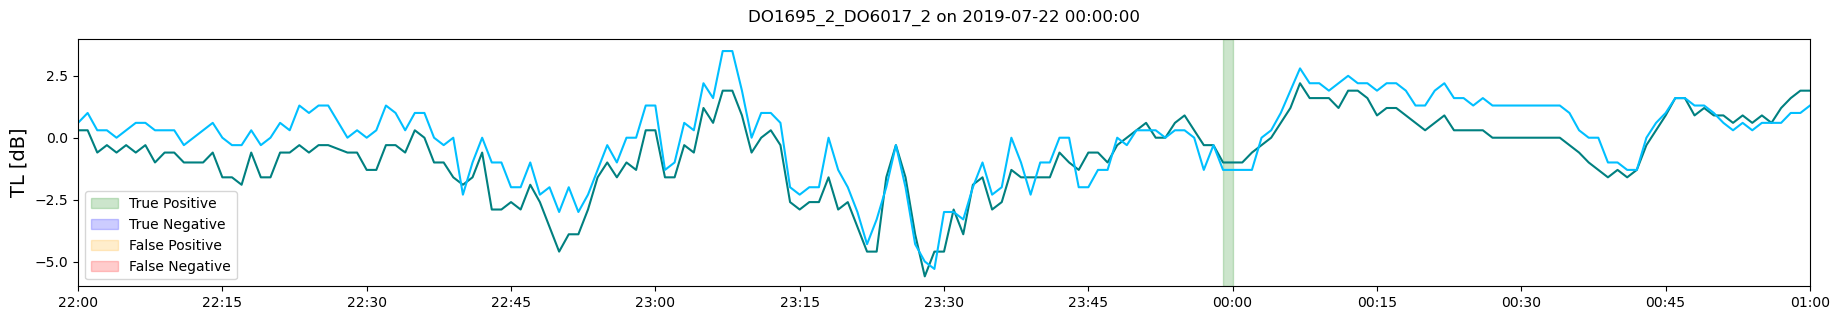

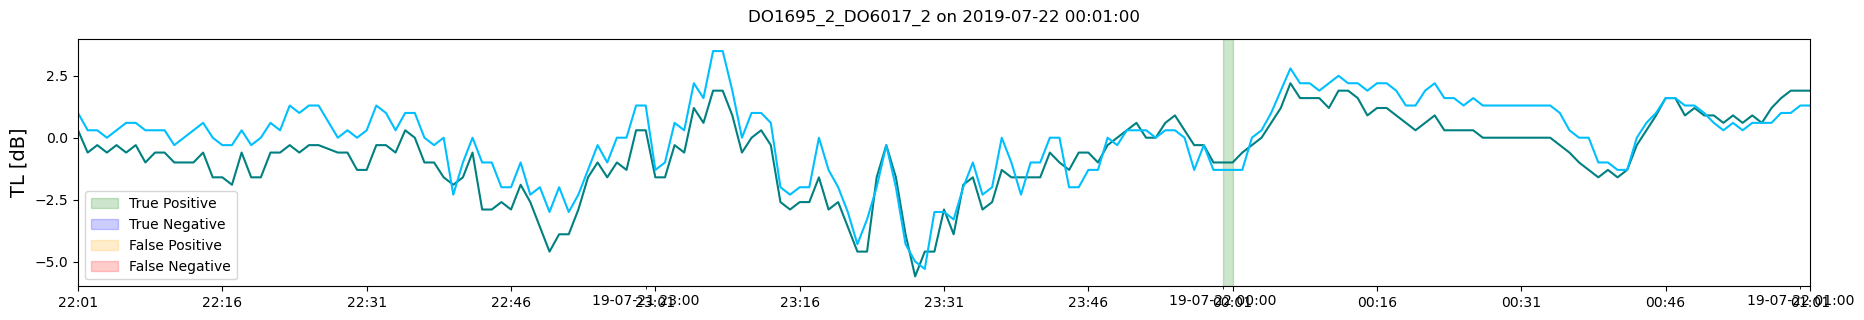

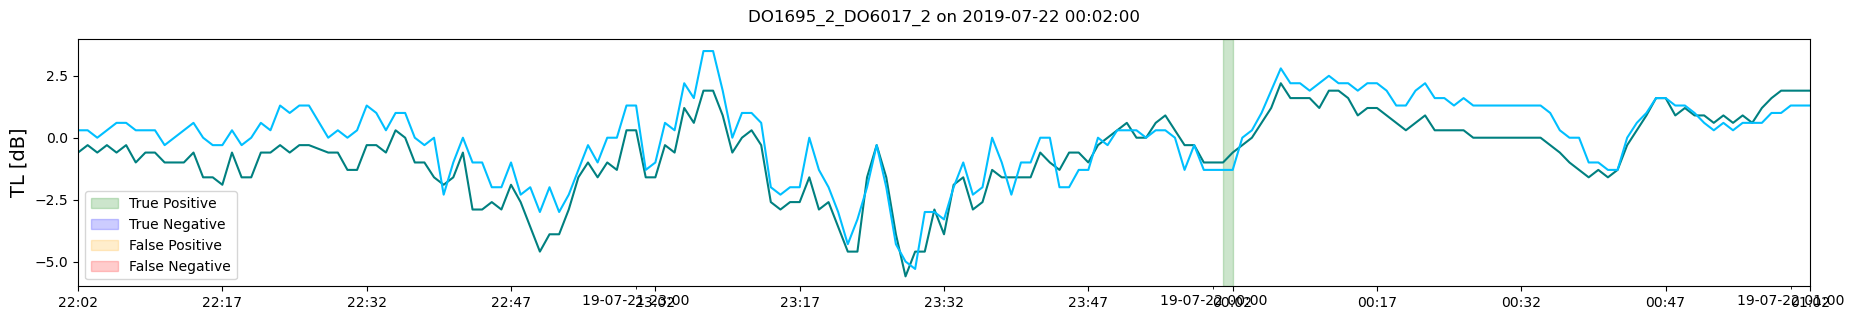

In [10]:
if model_config.plotting.validation_samples:
    plot_classified_samples(model, val_dataset, model_config, preproc_config, threshold=threshold, plot_example=True)

#### Evaluate model

41/41 [==============================] - 16s 366ms/step
MCC: 0.964
Precision: 0.954
Recall: 0.987
Accuracy: 0.990
AUC: 0.998 


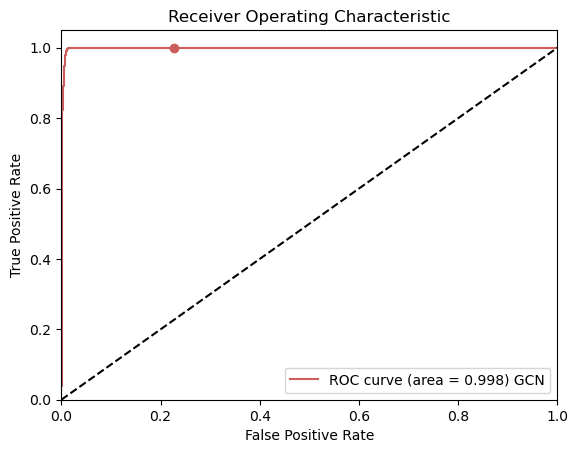

In [11]:
predictions = model.predict(test_dataset_GCN.map(
    wrapping_functions[0], call_numb).prefetch(call_numb)).flatten()
sensor_ids, anomaly_dates, anomaly_flags_true = extract_target_info(test_dataset_GCN.map(
        wrapping_functions[1], call_numb).prefetch(call_numb), anomaly_date_ind, ds_type=preproc_config.ds_type)
anomaly_flags_pred = np.where(predictions > threshold, 1, 0)
mcc, precision, recall, accuracy, auc_score, fpr, tpr, thr = calculate_metrics(anomaly_flags_true, anomaly_flags_pred, predictions, model_config)

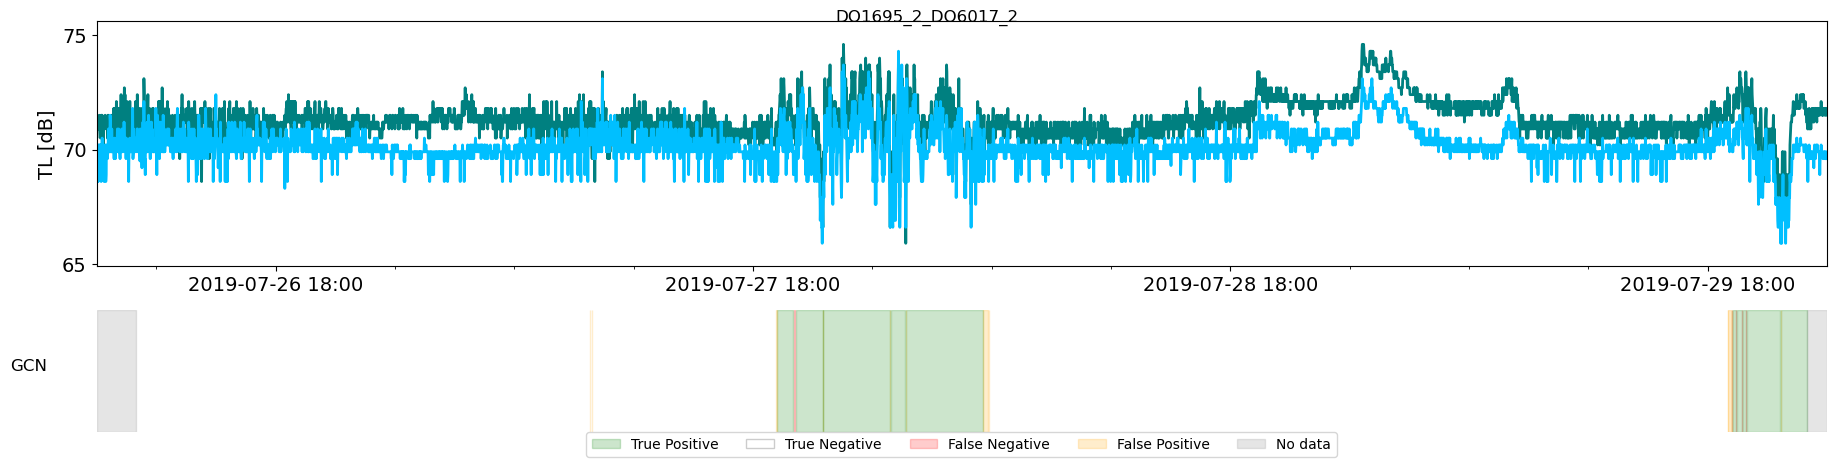

In [12]:
plot_results(sensor_ids, anomaly_dates, anomaly_flags_pred, anomaly_flags_true,
             predictions, preproc_config, model_config, False, plot_example=True)

### Define and train baseline model

#### Create batches of data

In [13]:
call_numb = tf.data.AUTOTUNE
train_dataset_baseline, preproc_config, wrapping_functions_baseline = create_batched_dataset(train_dataset, preproc_config, baseline=True)
train_dataset_baseline = train_dataset_baseline.map(wrapping_functions_baseline[0], call_numb).prefetch(call_numb)
val_dataset_baseline = create_batched_dataset(val_dataset, preproc_config, baseline=True)[0]
test_dataset_baseline = create_batched_dataset(test_dataset, preproc_config, shuffle=False, baseline=True)[0]

#### Define and train baseline model

In [14]:
model_config.train_baseline=False
#model_config.baseline_model.model_path = '../model_soilnet_baseline2'
#model_config.epochs = 2

In [15]:
if model_config.train_baseline:
    model_baseline = BaselineClassifier(model_config, preproc_config)
    history, model_baseline = train_model(model_baseline, model_config, preproc_config, train_dataset_baseline,
                        val_dataset_baseline.map(wrapping_functions_baseline[0], call_numb).prefetch(call_numb), baseline=True)
    model_baseline.save(model_config.baseline_model.model_path)
else:
    model_baseline = tf.keras.models.load_model(model_config.baseline_model.model_path, compile=False)
    model_baseline.compile(
        loss='binary_crossentropy',
        optimizer='adam', 
        metrics=[tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'), 
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.TruePositives(name='tp'),
                 tf.keras.metrics.FalsePositives(name='fp'),
                 tf.keras.metrics.TrueNegatives(name='tn'),
                 tf.keras.metrics.FalseNegatives(name='fn')],
        )

#### Plot results for the validation dataset

In [16]:
# Set the prediction threshold based on the best MCC
threshold_baseline, anomaly_date_ind_baseline = calculate_threshold(model_config, preproc_config, val_dataset,
                                                                    wrapping_functions_baseline, model_baseline, baseline=True)

56/56 [==============================] - 3s 38ms/step
Max MCC: 0.593 for threshold: 0.027


56/56 [==============================] - 2s 35ms/step


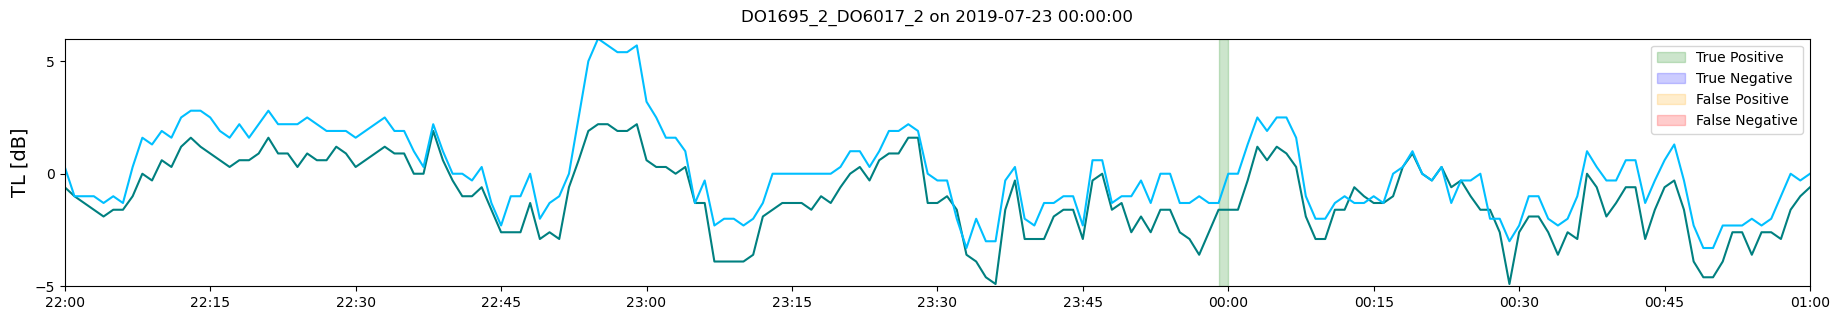

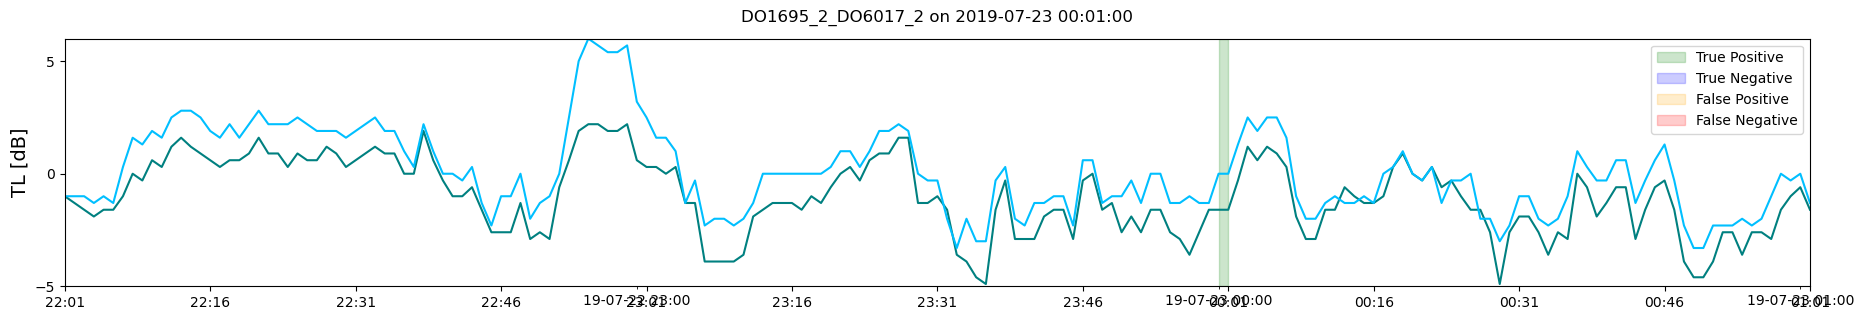

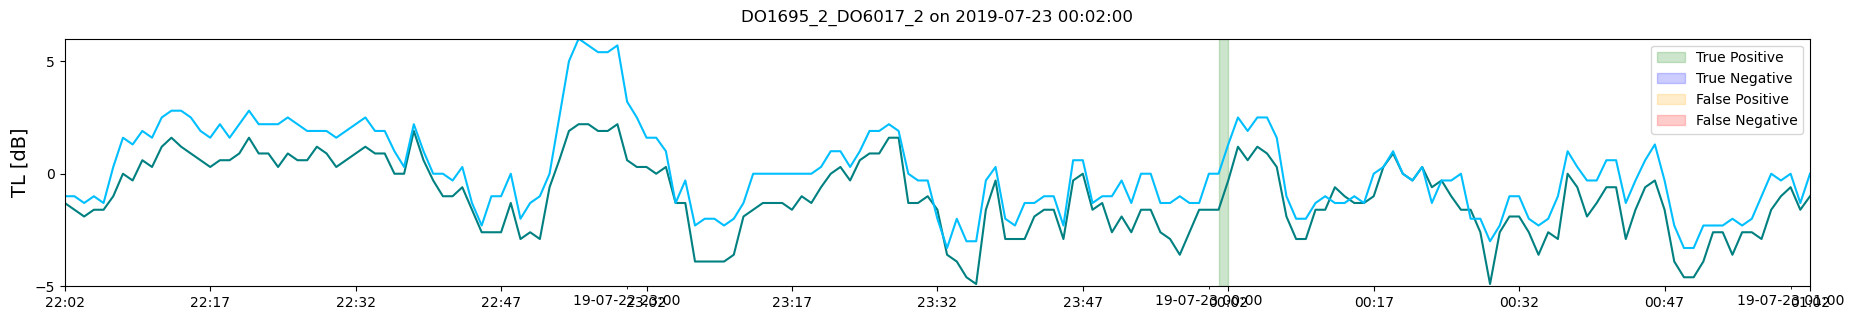

In [17]:
if model_config.plotting.validation_samples:
    plot_classified_samples(model_baseline, val_dataset,
                        model_config, preproc_config, threshold=threshold_baseline, baseline=True, plot_example=True)

#### Evaluate model

41/41 [==============================] - 2s 40ms/step
MCC: 0.502
Precision: 0.461
Recall: 0.799
Accuracy: 0.810
AUC: 0.825 


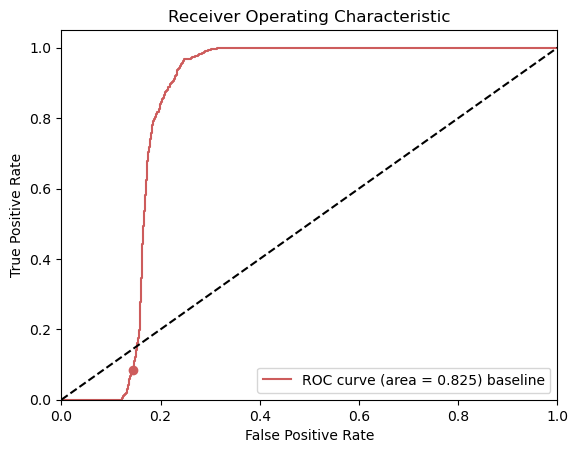

In [18]:
predictions_baseline = model_baseline.predict(test_dataset_baseline.map(
    wrapping_functions_baseline[0], call_numb).prefetch(call_numb)).flatten()
sensor_ids_baseline, anomaly_dates_baseline, anomaly_flags_true_baseline = extract_target_info(test_dataset_baseline.map(
        wrapping_functions_baseline[1], call_numb).prefetch(call_numb), anomaly_date_ind_baseline)
anomaly_flags_pred_baseline = np.where(predictions_baseline > threshold_baseline, 1, 0)
mcc_baseline, precision_baseline, recall_baseline, accuracy_baseline, auc_score_baseline, fpr_baseline, tpr_baseline, thr_baseline = calculate_metrics(
        anomaly_flags_true_baseline, anomaly_flags_pred_baseline, predictions_baseline, model_config, baseline=True)

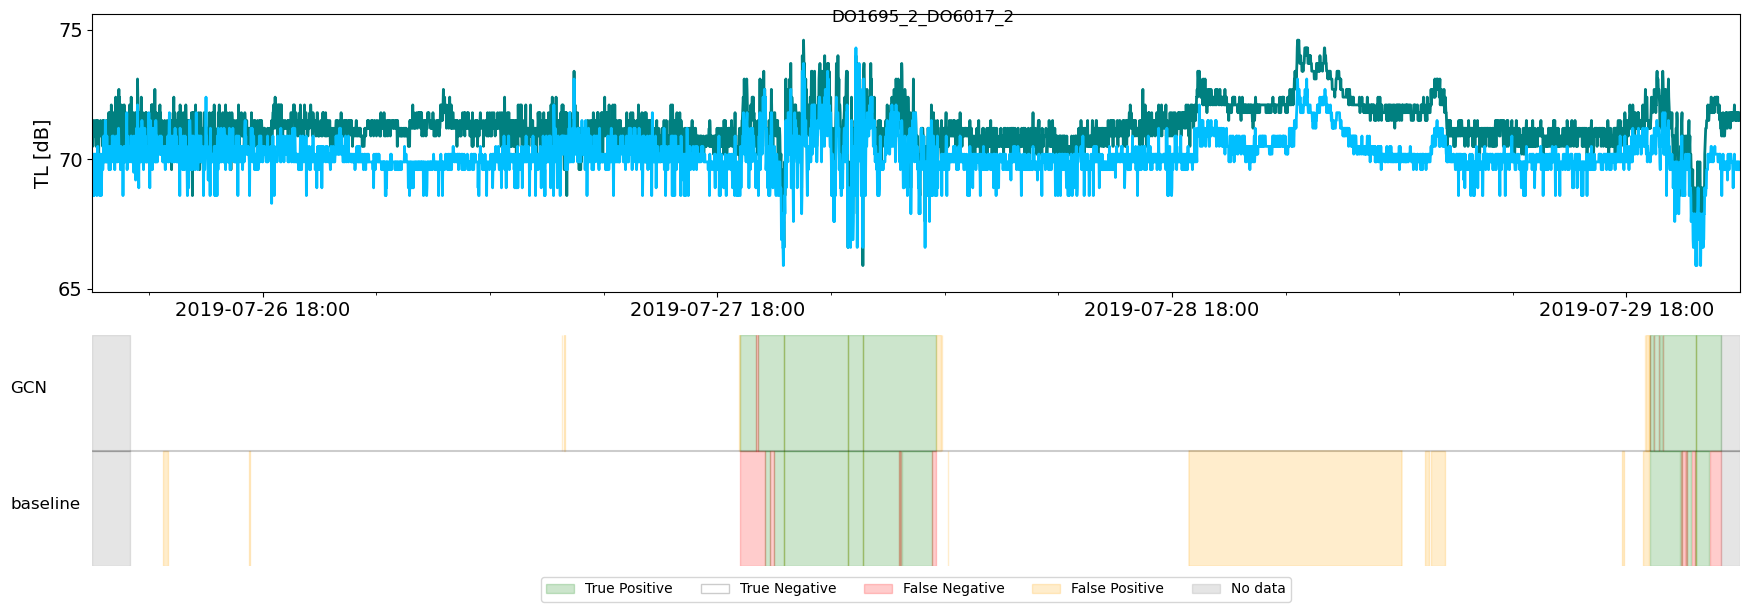

In [19]:
plot_results(sensor_ids, anomaly_dates, anomaly_flags_pred, anomaly_flags_true, predictions,
                 preproc_config, model_config, comparison=True, 
                 sensor_ids_baseline=sensor_ids_baseline, anomaly_dates_baseline=anomaly_dates_baseline,
                 anomaly_flags_pred_baseline=anomaly_flags_pred_baseline, anomaly_flags_true_baseline=anomaly_flags_true_baseline,
             predictions_baseline=predictions_baseline, plot_example=True)

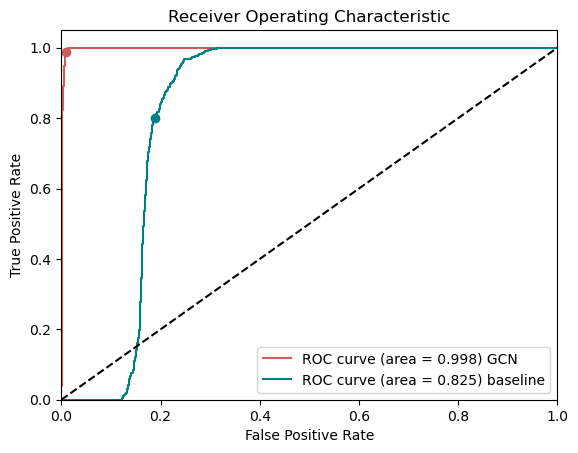

In [20]:
plot_roc_curves([fpr, fpr_baseline], [tpr, tpr_baseline], model_config, thresholds=[thr, thr_baseline],
                choosen_thresholds=[threshold, threshold_baseline],
                   outpath=os.path.join(model_config.plotting.outdir, 'ROC_curves.png'))